In [78]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o
from h2o.estimators.word2vec import H2OWord2vecEstimator

In [2]:
project_name = 'dropwizard'
version_name = 'v2.0.6'

n_cluster_divisible_arr = [5,7,10,15,20,25]
affinity_arr = ['euclidean', 'manhattan', 'cosine']
linkage_arr = ['complete', 'average', 'single']

n_cluster = 300
affinity = 'cosine'
linkage = 'single'

In [3]:
depends_dir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_depends/{project_name}/{project_name}_{version_name}.json'
rootdir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}'

In [4]:
print(rootdir)

C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/dropwizard/dropwizard_v2.0.6


In [5]:
full_dir_arr = []
for root, dirs, files in os.walk(rootdir):
    #print(root)
    #print(dirs)
    for element in files:
        if '.java' in element:
            dir_string = root + '\\' + element
            full_dir_arr.append(dir_string)

cluster_dict = {}
cluster_tree = {}


for element in full_dir_arr:
    element = element.split('\\')
    child = element[-1]
    parent = element[-2]
    cluster_tree[child] = parent

In [6]:
cluster_tree

{'MavenWrapperDownloader.java': 'wrapper',
 '__name__Application.java': 'java',
 '__name__Configuration.java': 'java',
 'AssetsBundle.java': 'assets',
 'AssetsBundleTest.java': 'assets',
 'Auth.java': 'auth',
 'AuthDynamicFeature.java': 'auth',
 'AuthenticationException.java': 'auth',
 'Authenticator.java': 'auth',
 'AuthFilter.java': 'auth',
 'AuthorizationContext.java': 'auth',
 'Authorizer.java': 'auth',
 'AuthValueFactoryProvider.java': 'auth',
 'CachingAuthenticator.java': 'auth',
 'CachingAuthorizer.java': 'auth',
 'DefaultUnauthorizedHandler.java': 'auth',
 'JSONUnauthorizedHandler.java': 'auth',
 'OptionalPrincipalContainerRequestValueFactory.java': 'auth',
 'PermitAllAuthorizer.java': 'auth',
 'PolymorphicAuthDynamicFeature.java': 'auth',
 'PolymorphicAuthValueFactoryProvider.java': 'auth',
 'PrincipalContainerRequestValueFactory.java': 'auth',
 'PrincipalImpl.java': 'auth',
 'UnauthorizedHandler.java': 'auth',
 'WebApplicationExceptionCatchingFilter.java': 'auth',
 'BasicCred

In [7]:
len(cluster_tree)

815

In [8]:
try:
    os.mkdir('raw_depends/' + project_name)
except:
    pass

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & ' + f"java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}" +  f' ../raw_depends/{project_name}/{project_name}_{version_name}' 
print(command)
os.system(command)

cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/dropwizard/dropwizard_v2.0.6 ../raw_depends/dropwizard/dropwizard_v2.0.6


0

In [8]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

847


In [9]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    print(len(depends_results['cells']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

    var_df = pd.DataFrame(var_array)
    var_df.columns = ['index_val', 'name']

    feature_list = {}
    feature_index = 2
    for element in depends_results['cells']:
        #print(element)
        try:
            for a in element['values']:
                if a not in feature_list:
                    feature_list[a] = feature_index
                    feature_index += 1
                #print(a['Call'])


        except:
            pass

    feature_arr = []
    for element in depends_results['cells']:
        #print(array)
        array = [0] * (len(feature_list) + 2)
        values = dict(element['values'])
        #print(element)
        array[0] = element['src']
        array[1] = element['dest']
        for feature in feature_list:
            try:
                value = values[feature]
                array[feature_list[feature]] = value
            except:
                pass
        #print(array)
        feature_arr.append(array)

    feature_df = pd.DataFrame(feature_arr)
    col_names = ['src', 'dest']
    for element in feature_list:
        col_names.append(element)
    feature_df.columns = col_names

    feature_df['sum'] = feature_df.sum(axis=1) - feature_df['src'] - feature_df['dest']
    #G = nx.Graph()
    G = nx.path_graph(len(depends_results['variables']))
    for index, row in feature_df.iterrows():
        G.add_edge(row['src'], row['dest'], weight=row['sum'])

    adj_mat = nx.adjacency_matrix(G)
    adj_mat_df = pd.DataFrame(adj_mat.toarray())
    np.fill_diagonal(adj_mat_df.values, adj_mat_df.values.max())
    x = adj_mat_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    adj_mat_df = pd.DataFrame(x_scaled)
    
    sum_dependency_df = nx.to_pandas_adjacency(G)
    sum_dependency_df['sum'] = sum_dependency_df.sum(axis=1)
    final_dependency_df = sum_dependency_df['sum']

847
2622


In [10]:
final_dependency_df

0       1.0
1       2.0
2       2.0
3      31.0
4      58.0
       ... 
842    23.0
843    41.0
844    29.0
845    42.0
846     5.0
Name: sum, Length: 847, dtype: float64

In [11]:
adj_mat_df

,0,1,2,3,4,5,6,7,8,9,...,837,838,839,840,841,842,843,844,845,846
0,1.000000,0.000787,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000787,1.000000,0.000787,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000787,1.000000,0.000787,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000787,1.000000,0.011802,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.011802,1.000000,0.000787,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000787,1.000000,0.000787,0.000000,0.000000,0.000000
843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.004721,0.0,0.004721,0.000000,0.000787,1.000000,0.003934,0.006294,0.000000
844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.004721,0.0,0.004721,0.000000,0.000000,0.003934,1.000000,0.000787,0.000000
845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.000000,0.0,0.020456,0.003147,0.000000,0.006294,0.000787,1.000000,0.000787


In [12]:
feature_df

,src,dest,Call,Create,Contain,Use,Import,Parameter,Annotation,Extend,Return,Implement,Cast,Throw,sum
0,834,829,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,389,303,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,591,579,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,127,312,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,682,681,2.0,0.0,2.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,569,779,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2618,519,512,24.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
2619,530,747,6.0,0.0,3.0,4.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,20.0
2620,519,513,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [14]:
print('Currently processing: ' + project_name + version_name)
command = f'java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/{project_name}/{project_name}_{version_name}'
print(command)
os.system(command)
os.rename('class.csv', project_name + '_' + version_name + '_class.csv')
os.rename('field.csv',  project_name + '_' + version_name + '_field.csv')
os.rename('method.csv', project_name + '_' + version_name + '_method.csv')

shutil.move(project_name + '_' + version_name + '_class.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_class.csv')
shutil.move(project_name + '_' + version_name + '_field.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_field.csv')
shutil.move(project_name + '_' + version_name + '_method.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_method.csv')

          

Currently processing: dropwizardv2.0.6
java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/dropwizard/dropwizard_v2.0.6


'ck_results_invi/dropwizard_v2.0.6_method.csv'

In [13]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
cluster_result = cluster.fit_predict(adj_mat_df)

ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
filename_a = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_a.rsf'
filename_b = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_b.rsf'

with open(filename_a, 'w') as f:
    for key, value in cluster_tree.items():
        f.write('contain ' + str(value).replace(" ",'') + ' ' + str(key).replace(' ','') + '\n')

arr_a_rsf = []
arr_b_rsf = []
with open(filename_b, 'w') as f:
    len_b_rsf = 0
    duplicate_array = []
    refactor_arr_pretty_print = []
    refactor_arr = []
    main_data_arr = []
    clustering_result_dict = {}
    num_line_affected = 0
    num_dependency = 0
    actual_num_of_classes_touched = 0
    for i in range(len(cluster_result)):
        #print(i)
        try:
            subject = var_df[var_df['index_val'] == i]['name'].values[0]
            #print(subject)
            #print(subject in cluster_tree)
            if subject in cluster_tree and subject not in duplicate_array:
                #print(element)
                duplicate_array.append(subject)
                string = "contain " + str(cluster_result[i]) + " " + subject + "\n"
                arr_b_rsf.append(subject)
                len_b_rsf += 1
                f.write(string)
                #print(subject)
                class_metrics = ck_metrics.loc[ck_metrics['class_name'] == subject].values.tolist()[0]
                
                #print(ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0])
                
                subjected_file = ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0]
                
                #print(subjected_file)
                
                num_dependency = final_dependency_df.iloc[cluster_result[i]]
                num_line_affected += sum(1 for line in open(subjected_file))
                
                
                class_metrics.append(num_dependency)
                class_metrics.append(num_line_affected)
                main_data_arr.append(class_metrics)
                
                
                ## Important
                ## This is assuming that during Depends, the file structure is already sorted
                ## I.e. going through the directory structure depth wise, not breath wise
                original_parent = cluster_tree[subject]
                try:
                    to_check_parent = clustering_result_dict[cluster_result[i]]
                    #print(original_parent, to_check_parent)
                    if original_parent != to_check_parent:
                        #print(i)
                        #refactor_arr.append(f'Move {subject} to {str(i)}')
                        #refactor_arr.append(f'Move {subject} to {str(cluster_result[i])}')
                        temp_arr = []
                        temp_arr.append(subject)
                        temp_arr.append(cluster_result[i-1])
                        refactor_arr.append(temp_arr)
                        refactor_arr_pretty_print.append(f'Move {subject} to {str(cluster_result[i-1])}')
                        actual_num_of_classes_touched += 1
                    
                    clustering_result_dict[cluster_result[i]] = to_check_parent
                except:
                    clustering_result_dict[cluster_result[i]] = original_parent
                
            else:
                #print(subject)
                pass
        except Exception as e:
            #print(e)
            pass
f.close()

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1 & ' + 'java MoJo ' + filename_a + ' ' + filename_b + ' >> ' + project_name + '/' + project_name + '_results.txt'
#print(command)
os.system(command)

0

In [14]:
cluster_result

array([223, 287, 215,   0,   0, 239, 185,   0, 184,   0,   0,   0,   0,
         0,   0, 294,   0, 285,   0, 168, 166, 289,   0,   0, 227,   0,
         0,   0,   0,   0,   0,   0, 183,   0,   0, 267,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 199,   0,   0, 186,   0,   0,   6,
         0,   0, 242, 217, 243,   0,   0,   0,   0,   0,   0,   0,   0,
        91,   0,  29,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        29,   0,   0,   0,   0,   0,   0,   0,   0, 290,  49,  55,   0,
         0,   0,   0, 238, 261,   0,   0,   0,   0,  49,  55, 231,   0,
         0, 273,   0, 218,   0,   0,   0,   0, 209,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 191,   0,
         0, 288,   0,   0, 265, 297, 299, 195, 224, 233, 211, 228, 221,
       255, 201, 207,   0,   0,   0,   0,   0,   0,   0,   0,   

In [15]:
print(len(refactor_arr_pretty_print))
refactor_arr_pretty_print

489


['Move AuthFilter.java to 185',
 'Move AuthenticationException.java to 184',
 'Move Authenticator.java to 0',
 'Move AuthorizationContext.java to 0',
 'Move Authorizer.java to 0',
 'Move CachingAuthenticator.java to 0',
 'Move CachingAuthorizer.java to 0',
 'Move JSONUnauthorizedHandler.java to 294',
 'Move PermitAllAuthorizer.java to 285',
 'Move PrincipalImpl.java to 289',
 'Move UnauthorizedHandler.java to 0',
 'Move BasicCredentialAuthFilter.java to 227',
 'Move BasicCredentials.java to 0',
 'Move ChainedAuthFilter.java to 0',
 'Move OAuthCredentialAuthFilter.java to 0',
 'Move AbstractAuthResourceConfig.java to 0',
 'Move AuthBaseTest.java to 0',
 'Move AuthFilterTest.java to 0',
 'Move CachingAuthenticatorTest.java to 183',
 'Move CachingAuthorizerTest.java to 0',
 'Move BasicAuthProviderTest.java to 267',
 'Move BasicCredentialsTest.java to 0',
 'Move BasicCustomAuthProviderTest.java to 0',
 'Move ChainedAuthProviderTest.java to 0',
 'Move OAuthCustomProviderTest.java to 0',
 'M

In [16]:
refactor_arr

[['AuthFilter.java', 185],
 ['AuthenticationException.java', 184],
 ['Authenticator.java', 0],
 ['AuthorizationContext.java', 0],
 ['Authorizer.java', 0],
 ['CachingAuthenticator.java', 0],
 ['CachingAuthorizer.java', 0],
 ['JSONUnauthorizedHandler.java', 294],
 ['PermitAllAuthorizer.java', 285],
 ['PrincipalImpl.java', 289],
 ['UnauthorizedHandler.java', 0],
 ['BasicCredentialAuthFilter.java', 227],
 ['BasicCredentials.java', 0],
 ['ChainedAuthFilter.java', 0],
 ['OAuthCredentialAuthFilter.java', 0],
 ['AbstractAuthResourceConfig.java', 0],
 ['AuthBaseTest.java', 0],
 ['AuthFilterTest.java', 0],
 ['CachingAuthenticatorTest.java', 183],
 ['CachingAuthorizerTest.java', 0],
 ['BasicAuthProviderTest.java', 267],
 ['BasicCredentialsTest.java', 0],
 ['BasicCustomAuthProviderTest.java', 0],
 ['ChainedAuthProviderTest.java', 0],
 ['OAuthCustomProviderTest.java', 0],
 ['OAuthProviderTest.java', 0],
 ['JsonPrincipal.java', 0],
 ['NoAuthPolymorphicPrincipalEntityResource.java', 0],
 ['NoAuthPoly

In [17]:
refactor_df = pd.DataFrame(refactor_arr)
refactor_df.columns = ['class_name', 'refactor_destination']
refactor_df.head()

,class_name,refactor_destination
0,AuthFilter.java,185
1,AuthenticationException.java,184
2,Authenticator.java,0
3,AuthorizationContext.java,0
4,Authorizer.java,0


In [120]:
temp_dataframe = pd.DataFrame(main_data_arr)
temp_columns = list(ck_metrics.columns)
temp_columns.append('num_dependency')
temp_columns.append('num_line_affected')
temp_dataframe.columns = temp_columns

## For the groupby operation below
#temp_dataframe['placeholder_key'] = 'placeholder_key'

In [121]:
temp_dataframe.head()

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,variablesQty,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name,num_dependency,num_line_affected
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,MavenWrapperDownloader,class,1,9,1,17,1,2,2,...,13,4,0,0,0,82,1,MavenWrapperDownloader.java,37.0,110
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,$.$,class,2,7,1,0,6,4,1,...,2,0,0,0,0,12,1,__name__Application.java,8.0,139
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.assets.AssetsBundle,class,7,14,1,9,0,10,0,...,8,1,0,0,0,92,1,AssetsBundle.java,1.0,266
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.assets.AssetsBundleTest,class,12,9,1,25,4,9,0,...,7,0,0,0,0,51,1,AssetsBundleTest.java,1.0,423
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthDynamicFeature,class,11,13,1,9,0,4,0,...,8,4,0,0,0,84,1,AuthDynamicFeature.java,19.0,516


In [122]:
temp_dataframe = pd.merge(refactor_df, temp_dataframe, on='class_name', how='left')

In [123]:
temp_dataframe.head()

,class_name,refactor_destination,file,class,type,cbo,wmc,dit,rfc,lcom,...,mathOperationsQty,variablesQty,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,num_dependency,num_line_affected
0,AuthFilter.java,185,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthFilter,class,15,4,1,9,0,...,0,10,2,1,1,2,96,1025,1.0,690
1,AuthenticationException.java,184,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthenticationException,class,0,3,3,0,3,...,0,1,0,0,0,0,37,1,1.0,802
2,Authenticator.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.Authenticator,interface,2,1,1,0,0,...,0,0,-1,0,0,0,41,1,1.0,829
3,AuthorizationContext.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthorizationContext,class,4,9,1,3,0,...,0,4,0,0,0,0,21,0,1.0,876
4,Authorizer.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.Authorizer,interface,4,2,1,1,1,...,0,0,0,0,0,0,30,1,1.0,913


In [124]:
project_refactoring_data_agg = temp_dataframe.groupby(['class_name'], as_index=False).agg({
       'cbo': ['mean', 'min', 'max','std'], 
        'wmc': ['mean', 'min', 'max','std'], 
        'dit': ['mean', 'min', 'max','std'], 
        'rfc': ['mean', 'min', 'max','std'], 
        'lcom': ['mean', 'min', 'max','std'],
        'totalMethods': ['mean', 'min', 'max','std'], 
        'staticMethods': ['mean', 'min', 'max','std'],
        'publicMethods': ['mean', 'min', 'max','std'], 
        'privateMethods': ['mean', 'min', 'max','std'],
        'protectedMethods': ['mean', 'min', 'max','std'], 
        'defaultMethods': ['mean', 'min', 'max','std'], 
        'abstractMethods': ['mean', 'min', 'max','std'], 
        'finalMethods': ['mean', 'min', 'max','std'],
        'synchronizedMethods': ['mean', 'min', 'max','std'],
        'totalFields': ['mean', 'min', 'max','std'], 
        'staticFields': ['mean', 'min', 'max','std'], 
        'publicFields': ['mean', 'min', 'max','std'],
        'privateFields': ['mean', 'min', 'max','std'],
        'protectedFields': ['mean', 'min', 'max','std'],
        'defaultFields': ['mean', 'min', 'max','std'], 
        'finalFields': ['mean', 'min', 'max','std'],
        'synchronizedFields': ['mean', 'min', 'max','std'],
        'nosi': ['mean', 'min', 'max','std'], 
        'loc': ['mean', 'min', 'max','std'], 
        'returnQty': ['mean', 'min', 'max','std'],
        'loopQty': ['mean', 'min', 'max','std'],
        'comparisonsQty': ['mean', 'min', 'max','std'],
        'tryCatchQty': ['mean', 'min', 'max','std'],
        'parenthesizedExpsQty': ['mean', 'min', 'max','std'],
        'stringLiteralsQty': ['mean', 'min', 'max','std'],
        'numbersQty': ['mean', 'min', 'max','std'], 
        'assignmentsQty': ['mean', 'min', 'max','std'],
        'mathOperationsQty': ['mean', 'min', 'max','std'], 
        'variablesQty': ['mean', 'min', 'max','std'], 
        'maxNestedBlocks': ['mean', 'min', 'max','std'],
        'anonymousClassesQty': ['mean', 'min', 'max','std'],
        'subClassesQty': ['mean', 'min', 'max','std'],
        'lambdasQty': ['mean', 'min', 'max','std'],
        'uniqueWordsQty': ['mean', 'min', 'max','std'],
        'modifiers': ['mean', 'min', 'max','std'],
        'num_dependency': ['mean'],
        'num_line_affected': ['mean'],
})

In [125]:
project_refactoring_data_agg

class_name  cbo              wmc              dit  \
                                       mean min max std mean min max std mean   
0         AbstractAppenderFactory.java   31  31  31 NaN   28  28  28 NaN    1   
1      AbstractAuthResourceConfig.java    8   8   8 NaN    5   5   5 NaN    3   
2                     AbstractDAO.java   12  12  12 NaN   17  17  17 NaN    1   
3                 AbstractDAOTest.java   19  19  19 NaN   17  17  17 NaN    2   
4               AbstractHttp2Test.java   12  12  12 NaN    6   6   6 NaN    1   
..                                 ...  ...  ..  ..  ..  ...  ..  ..  ..  ...   
484            ViolationCollector.java    6   6   6 NaN   18  18  18 NaN    1   
485         WrappedFailingExample.java    4   4   4 NaN    2   2   2 NaN    1   
486    WrappedValidRepresentation.java    4   4   4 NaN    2   2   2 NaN    1   
487      YamlConfigurationFactory.java    6   6   6 NaN    1   1   1 NaN    2   
488  YamlConfigurationFactoryTest.java    5   5   5 NaN    3   3   3 NaN    2   

     ... uniqueWordsQty               modifiers                  \
     ...           mean  min  max std      mean   min   max std   
0    ...            140  140  140 NaN      1025  1025  1025 NaN   
1    ...             30   30   30 NaN      1025  1025  1025 NaN   
2    ...            132  132  132 NaN         1     1     1 NaN   
3    ...             74   74   74 NaN         1     1     1 NaN   
4    ...             49   49   49 NaN         1     1     1 NaN   
..   ...            ...  ...  ...  ..       ...   ...   ...  ..   
484  ...             95   95   95 NaN         1     1     1 NaN   
485  ...              6    6    6 NaN         1     1     1 NaN   
486  ...              6    6    6 NaN         1     1     1 NaN   
487  ...             45   45   45 NaN         1     1     1 NaN   
488  ...             46   46   46 NaN         1     1     1 NaN   

    num_dependency num_line_affected  
              mean              mean  
0              1.0             44006  
1              1.0              1937  
2              1.0             20483  
3              1.0             21564  
4              1.0             23834  
..             ...               ...  
484            1.0             66497  
485            1.0             35758  
486            1.0             35781  
487            1.0             10442  
488            1.0             11385  

[489 rows x 163 columns]

In [126]:
columns_to_agg = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom',
       'totalMethods', 'staticMethods', 'publicMethods', 'privateMethods',
       'protectedMethods', 'defaultMethods', 'abstractMethods', 'finalMethods',
       'synchronizedMethods', 'totalFields', 'staticFields', 'publicFields',
       'privateFields', 'protectedFields', 'defaultFields', 'finalFields',
       'synchronizedFields', 'nosi', 'loc', 'returnQty', 'loopQty',
       'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'anonymousClassesQty', 'subClassesQty', 'lambdasQty', 'uniqueWordsQty',
       'modifiers'
]


project_refactoring_data_agg_column_names = ['class_name']
for element in columns_to_agg:
    project_refactoring_data_agg_column_names.append(element + '_mean')
    project_refactoring_data_agg_column_names.append(element + '_min')
    project_refactoring_data_agg_column_names.append(element + '_max')
    project_refactoring_data_agg_column_names.append(element + '_std')
    
    
project_refactoring_data_agg_column_names.append('num_dependency_mean')
project_refactoring_data_agg_column_names.append('num_line_affected_mean')

In [127]:
project_refactoring_data_agg.columns = project_refactoring_data_agg_column_names

In [130]:
project_refactoring_data_agg['refactor_destination'] = temp_dataframe['refactor_destination']
project_refactoring_data_agg['file'] = temp_dataframe['file']
project_refactoring_data_agg = project_refactoring_data_agg.replace(to_replace= r'C:\\Users\\tanji\\Desktop\\SoftwareRemodularization\\raw_sourcecode', value= '', regex=True)
project_refactoring_data_agg = project_refactoring_data_agg.replace(to_replace= r'\\', value= ' ', regex=True)


In [131]:
project_refactoring_data_agg

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
0,AbstractAppenderFactory.java,31,31,31,NaN,28,28,28,NaN,1,...,140,NaN,1025,1025,1025,NaN,1.0,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
1,AbstractAuthResourceConfig.java,8,8,8,NaN,5,5,5,NaN,3,...,30,NaN,1025,1025,1025,NaN,1.0,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
2,AbstractDAO.java,12,12,12,NaN,17,17,17,NaN,1,...,132,NaN,1,1,1,NaN,1.0,20483,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
3,AbstractDAOTest.java,19,19,19,NaN,17,17,17,NaN,2,...,74,NaN,1,1,1,NaN,1.0,21564,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
4,AbstractHttp2Test.java,12,12,12,NaN,6,6,6,NaN,1,...,49,NaN,1,1,1,NaN,1.0,23834,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,ViolationCollector.java,6,6,6,NaN,18,18,18,NaN,1,...,95,NaN,1,1,1,NaN,1.0,66497,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
485,WrappedFailingExample.java,4,4,4,NaN,2,2,2,NaN,1,...,6,NaN,1,1,1,NaN,1.0,35758,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
486,WrappedValidRepresentation.java,4,4,4,NaN,2,2,2,NaN,1,...,6,NaN,1,1,1,NaN,1.0,35781,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
487,YamlConfigurationFactory.java,6,6,6,NaN,1,1,1,NaN,2,...,45,NaN,1,1,1,NaN,1.0,10442,0,dropwizard dropwizard_v2.0.6 dropwizard-views...


In [132]:
project_refactoring_data_agg = project_refactoring_data_agg.fillna(0)

In [133]:
project_refactoring_data_agg[project_refactoring_data_agg['class_name']== 'AuthFilter.java']

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
35,AuthFilter.java,15,15,15,0.0,4,4,4,0.0,1,...,96,0.0,1025,1025,1025,0.0,1.0,690,243,dropwizard dropwizard_v2.0.6 dropwizard-clien...


In [96]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,39 mins 31 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,7 months and 7 days !!!
H2O_cluster_name:,H2O_from_python_tanji_4pbor3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.982 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [134]:
model_path = "models/EffortEstimationModelv3/Log_Regression_GBM_grid__1_AutoML_20220228_154246_model_3"
saved_model = h2o.load_model(model_path)

In [135]:
#project_refactoring_data_agg.drop(['placeholder_key'],axis=1, inplace=True)

In [136]:
project_refactoring_data_agg

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
0,AbstractAppenderFactory.java,31,31,31,0.0,28,28,28,0.0,1,...,140,0.0,1025,1025,1025,0.0,1.0,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
1,AbstractAuthResourceConfig.java,8,8,8,0.0,5,5,5,0.0,3,...,30,0.0,1025,1025,1025,0.0,1.0,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
2,AbstractDAO.java,12,12,12,0.0,17,17,17,0.0,1,...,132,0.0,1,1,1,0.0,1.0,20483,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
3,AbstractDAOTest.java,19,19,19,0.0,17,17,17,0.0,2,...,74,0.0,1,1,1,0.0,1.0,21564,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
4,AbstractHttp2Test.java,12,12,12,0.0,6,6,6,0.0,1,...,49,0.0,1,1,1,0.0,1.0,23834,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,ViolationCollector.java,6,6,6,0.0,18,18,18,0.0,1,...,95,0.0,1,1,1,0.0,1.0,66497,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
485,WrappedFailingExample.java,4,4,4,0.0,2,2,2,0.0,1,...,6,0.0,1,1,1,0.0,1.0,35758,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
486,WrappedValidRepresentation.java,4,4,4,0.0,2,2,2,0.0,1,...,6,0.0,1,1,1,0.0,1.0,35781,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
487,YamlConfigurationFactory.java,6,6,6,0.0,1,1,1,0.0,2,...,45,0.0,1,1,1,0.0,1.0,10442,0,dropwizard dropwizard_v2.0.6 dropwizard-views...


In [137]:
prediction_df = h2o.H2OFrame(project_refactoring_data_agg)

In [138]:
prediction_df

class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
AbstractAppenderFactory.java,31,31,31,0,28,28,28,0,1,1,1,0,25,25,25,0,199,199,199,0,23,23,23,0,0,0,0,0,20,20,20,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,0,0,0,0,6,6,6,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,167,167,167,0,13,13,13,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,3,3,3,0,4,4,4,0,22,22,22,0,1,1,1,0,13,13,13,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,140,140,140,0,1025,1025,1025,0,1,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthFilter.java
AbstractAuthResourceConfig.java,8,8,8,0,5,5,5,0,3,3,3,0,6,6,6,0,10,10,10,0,5,5,5,0,0,0,0,0,1,1,1,0,0,0,0,0,4,4,4,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,30,30,0,1025,1025,1025,0,1,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthenticationException.java
AbstractDAO.java,12,12,12,0,17,17,17,0,1,1,1,0,22,22,22,0,106,106,106,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,14,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,1

In [139]:
preds = saved_model.predict(prediction_df)

In [140]:
preds

predict
0.882921
0.273833
1.55344
1.3046
0.985475
0.192724
-0.451966
0.713375
0.956342
-0.0243257


In [141]:
pd_preds = preds.as_data_frame()

In [142]:
prediction_df['refactoring_perc_time_taken_log']= preds['predict']
prediction_df.head()

class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,refactoring_perc_time_taken_log
AbstractAppenderFactory.java,31,31,31,0,28,28,28,0,1,1,1,0,25,25,25,0,199,199,199,0,23,23,23,0,0,0,0,0,20,20,20,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,0,0,0,0,6,6,6,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,167,167,167,0,13,13,13,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,3,3,3,0,4,4,4,0,22,22,22,0,1,1,1,0,13,13,13,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,140,140,140,0,1025,1025,1025,0,1,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthFilter.java,0.882921
AbstractAuthResourceConfig.java,8,8,8,0,5,5,5,0,3,3,3,0,6,6,6,0,10,10,10,0,5,5,5,0,0,0,0,0,1,1,1,0,0,0,0,0,4,4,4,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,30,30,0,1025,1025,1025,0,1,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthenticationException.java,0.273833
AbstractDAO.java,12,12,12,0,17,17,17,0,1,1,1,0,22,22,22,0,106,106,106,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,14,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

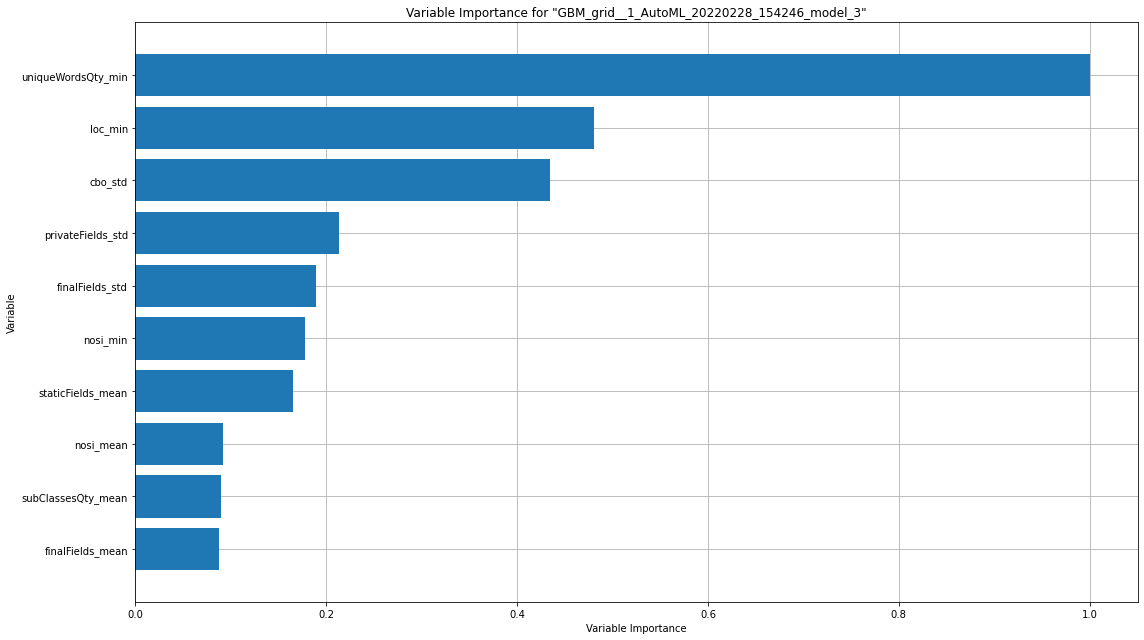

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\ProgramData\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


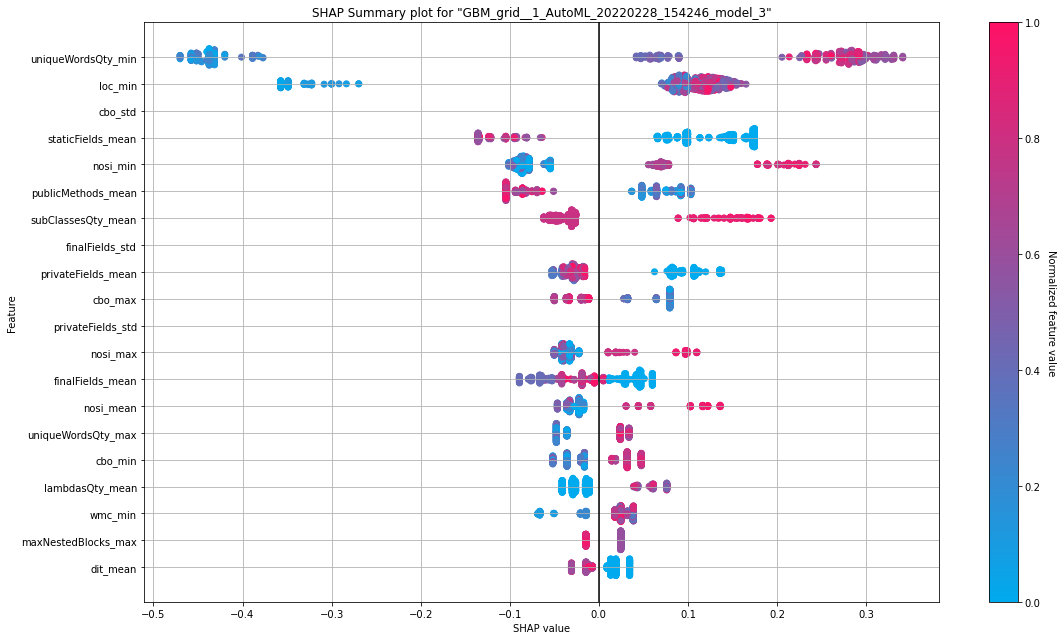

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

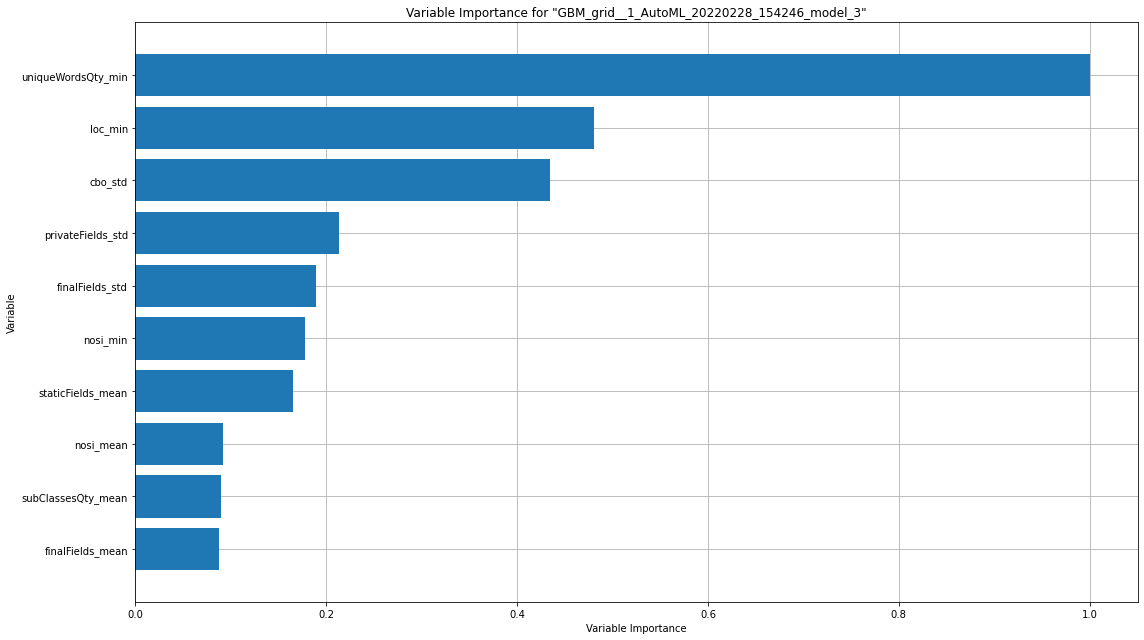

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

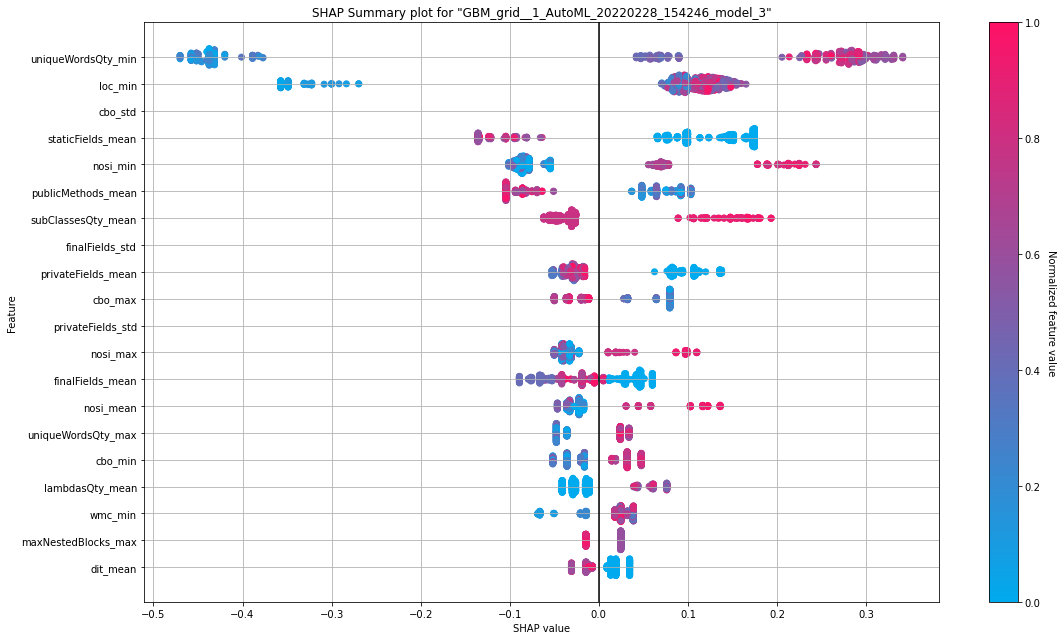

In [143]:
saved_model.explain(prediction_df, include_explanations=["varimp",'shap_summary'])

In [144]:
pd_preds['predicted_time'] = np.exp(pd_preds['predict'])
pd_preds['class_name'] = project_refactoring_data_agg['class_name']
pd_preds['refactor_destination'] = project_refactoring_data_agg['refactor_destination']

In [145]:
print(pd_preds.shape)
pd_preds.head()

(489, 4)


,predict,predicted_time,class_name,refactor_destination
0,0.882921,2.417951,AbstractAppenderFactory.java,185
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184
2,1.553440,4.727706,AbstractDAO.java,0
3,1.304600,3.686213,AbstractDAOTest.java,0
4,0.985475,2.679083,AbstractHttp2Test.java,0


In [146]:
pd_preds.to_csv('pipeline_prediction_output.csv', index=False)

In [147]:
refactor_arr

[['AuthFilter.java', 185],
 ['AuthenticationException.java', 184],
 ['Authenticator.java', 0],
 ['AuthorizationContext.java', 0],
 ['Authorizer.java', 0],
 ['CachingAuthenticator.java', 0],
 ['CachingAuthorizer.java', 0],
 ['JSONUnauthorizedHandler.java', 294],
 ['PermitAllAuthorizer.java', 285],
 ['PrincipalImpl.java', 289],
 ['UnauthorizedHandler.java', 0],
 ['BasicCredentialAuthFilter.java', 227],
 ['BasicCredentials.java', 0],
 ['ChainedAuthFilter.java', 0],
 ['OAuthCredentialAuthFilter.java', 0],
 ['AbstractAuthResourceConfig.java', 0],
 ['AuthBaseTest.java', 0],
 ['AuthFilterTest.java', 0],
 ['CachingAuthenticatorTest.java', 183],
 ['CachingAuthorizerTest.java', 0],
 ['BasicAuthProviderTest.java', 267],
 ['BasicCredentialsTest.java', 0],
 ['BasicCustomAuthProviderTest.java', 0],
 ['ChainedAuthProviderTest.java', 0],
 ['OAuthCustomProviderTest.java', 0],
 ['OAuthProviderTest.java', 0],
 ['JsonPrincipal.java', 0],
 ['NoAuthPolymorphicPrincipalEntityResource.java', 0],
 ['NoAuthPoly

In [148]:
pd_preds.head()

,predict,predicted_time,class_name,refactor_destination
0,0.882921,2.417951,AbstractAppenderFactory.java,185
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184
2,1.553440,4.727706,AbstractDAO.java,0
3,1.304600,3.686213,AbstractDAOTest.java,0
4,0.985475,2.679083,AbstractHttp2Test.java,0


In [149]:
pd_preds['file'] = project_refactoring_data_agg['file']
pd_preds.head()

,predict,predicted_time,class_name,refactor_destination,file
0,0.882921,2.417951,AbstractAppenderFactory.java,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
2,1.553440,4.727706,AbstractDAO.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
3,1.304600,3.686213,AbstractDAOTest.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
4,0.985475,2.679083,AbstractHttp2Test.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
